In [ ]:
#################################################################
#   Simple Policy Model 
#       By Colin Gordon
# 
#       Description
#         This script was written as a means to model
#         the pricing of policies with mulitple property casuality
#         conditions. 
#         
#         The model simply assumes that there are an average 
#         number events occur during the year that can occur any time
#         and are few in nature (Poisson averages)
#         The pricing of the events are modeled using exponential distributions
#         with a mean cost per an event. Reason to model it as an exponential
#         distribution is due to it being the highest entropy distribution
#         for claims size being of value over 0 with a defined average
#
#
#         
#
#
#
#
#
#
#
#
#################################################################

# IIIIIIIIIIIIIIIIIIIII Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from joblib import Parallel, delayed
import multiprocessing

In [ ]:
# CCCCCCCCCCCCCCCCCCCC Classes
class VariableClaim:
    ###########################
    # 
    # Synopsis:
    # This is a model based on claims that
    # have an exponential cost distribution for the client 
    # (higest entropy cost distribution)
    # The claims are assumed to be probabilistically 
    # independent and could occur at any time modeling
    # the claim as a Poisson distribution. This particular
    # class contains all of the necessary fields to model 
    # a claim with these mathematical conditions from epirical
    # data.
    #
    # Documentation:
    # https://www.overleaf.com/project/656a648468b40244fcfe3290
    # 
    # Parameters:
    #
    # __Name:
    # This is the name of the claim which can be used as an ID
    #
    # __Description:
    # This is a field that the user could fill to describe the claim
    #
    # __EventRate:
    # This is the Poisson rate of the event occuring per client during the
    # duration of the policy
    #
    # __CostMean: 
    # This is the average cost for the client 
    # of a claim gathered from empirical sources
    #
    # __CostBound:
    # This is the highest cost possible for the 
    # client to endure (total loss of property)
    # program will interpret a 0.0 as no bound
    #
    # __MaxClaim:
    # This is the maximum number of claims that
    # could be claimed by one client per policy duration
    #
    # __Deductible:
    # This is the deductible that the client pays
    #
    # __PolicyLimit:
    # This is the maximal limit that the policy pays out
    # for one claim. Program will interpret a 0.0 as no limit
    #
    # __PolicyRate:
    # This is a ratio that determines how much of 
    # the cost of damages will the insurer pay after the
    # deductible
    #
    #__LearningRate:
    # This is the learning rate of the effective Cost mean
    # should not be a worry unless the cost bound is close
    # to the mean (within a factor of 2). the smaller the 
    # rate the slower it will learn with less divergence
    #
    ###########################
    # private defining variables
    __Name = ''
    __Description = ''
    __EventRate = 1.0
    __CostMean = 1.0
    __CostBound = 0.0 # cost bounds are the maximal possible cost for the client 
    __MaxClaim = 10.0 # Max number of claims 
    __Deductible = 0.0 # no deductible always is equal to zero
    __PolicyLimit = 0.0 # no Limit is default as zero for these purpose
    __PolicyRate = 1.0 # default rate is 1.0 unless specified.
    __EffCostMean = 0.0 # assumed to be zero unless calculated
    __LearningRate = 0.05 # for finding the EffCostMean
    
    ##################### INITIATE POLICY ######################
    # Initiate policy
    def __init__(self, 
                 name: str,
                 description: str,
                 eventRate: float, 
                 costMean: float,
                 costBound:float,
                 maxClaim: float,
                 deductible: float, 
                 policyLimit: float, 
                 policyRate: float
                ):
        self.__Name = name
        self.__Description = description
        self.__EventRate = eventRate
        self.__CostMean = costMean
        self.__CostBound = costBound
        self.__MaxClaim = maxClaim
        self.__Deductible = deductible
        self.__PolicyLimit = policyLimit
        self.__PolicyRate = policyRate
        self.fix_limit_given_bound()
        self.effective_cost_mean()
    
    ###################### STANDARD MODIFIERS #######################
    # seters 
    def set_name(self,
                 name: str):
        self.__Name = name
    def set_description(self,
                       description: str):
        self.__Description = description
    
    def set_event_rate(self,
                      eventRate: float):
        self.__EventRate = eventRate
    
    def set_cost_mean(self,
                     costMean:float):
        self.__CostMean = costMean
        self.effective_cost_mean()
    
    def set_cost_bound(self,
                      costBound:float):
        self.__CostBound = costBound
        self.fix_limit_given_bound()
        self.effective_cost_mean()
    
    def set_max_claim(self,
                     maxClaim:float):
        self.__MaxClaim = maxClaim
    
    def set_deductible(self, 
                       deductible: float):
        self.__Deductible = deductible
        
    def set_limit(self,
                  policyLimit: float):
        self.__PolicyLimit = policyLimit
    
    def set_rate(self,
                 policyRate: float):
        self.__PolicyRate = policyRate
    
    def set_learning(self,
                    learning:float):
        self.__LearningRate = learning
        
    # geters
    def get_name(self)->str:
        return self.__Name 
    
    def get_description(self)->str:
        return self.__Description 
    
    def get_event_rate(self)->float:
        return self.__EventRate
    
    def get_cost_mean(self)->float:
        return self.__CostMean
    
    def get_cost_bound(self)->float:
        return self.__CostBound 
    
    def get_max_claim(self)->float:
        return self.__MaxClaim
        
    def get_deductible(self)->float:
        return self.__Deductible
    
    def get_limit(self)->float:
        return self.__PolicyLimit
    
    def get_rate(self)->float:
        return self.__PolicyRate
    
    def get_event_rate(self)->float:
        return self.__EventRate
    
    def get_effective_mean(self)->float:
        return self.__EffCostMean
    
    def get_learning(self)->float:
        return self.__LearningRate
    
    ########################## ADVANCED METHODS #########################
    def effective_cost_mean(self):
        ###########################
        # Synopsis:
        # this is used to calculate the Theta term
        # used in equation 24 of the paper listed
        # in the description
        ###########################
        
        #VVVVVVVVVVVVVVVVVVVVVVVVVV adjustable Varaiables
        convergenceParameter = 0.0001
        nearZero = 0.0001
        maxIterations = 1000
        numberOfConvergences = 5
        learningRate = self.get_learning()
        learningRatePlus1 = 1.0 + learningRate
        learningRateMinus1 = 1.0 - learningRate
        
        #MMMMMMMMMMMMMMMMMMMMMMMMMM Main
        foundConvergence=0
        convergenceBoolean = False
        
        # This condition is true if the bound is set to zero
        # a bound set to zero means the true bound is infinite
        if self.get_cost_bound() == 0.0:
            self.__EffCostMean = self.get_cost_mean()
        else: 
            # if a bound is set, then we use Newton's method 
            # to calculate the effective average if there were no bound
            
            # first estimate of the true average is the empirical mean
            effCostMean = self.get_cost_mean()
            
            # This iterates through multiple iterations of Newton's method
            # see equations 25 and 26 in paper
            # Note: there is a problem when the bound is a factor of 2 of the average computationally.
            for i in range(maxIterations):
                boundTerm = math.exp(self.get_cost_bound()/effCostMean)
                denominator = self.get_cost_bound()*self.get_cost_bound()*boundTerm + effCostMean*effCostMean*(2*boundTerm - boundTerm*boundTerm - 1)
                numerator = boundTerm - 1 # term used twice
                multiplyFraction = effCostMean*effCostMean*((effCostMean - self.get_cost_mean())*numerator - self.get_cost_bound())
                
                diff = (multiplyFraction*numerator)/denominator
                
                # This condition keeps the function learning 
                # slower than the learningRate, reducing the risk
                # of no convergence
                relativeDiff = abs(diff/effCostMean)
                if(relativeDiff<learningRate):
                    effCostMean = effCostMean + diff
                elif(diff<0):
                    effCostMean = learningRateMinus1*effCostMean
                else:
                    effCostMean = learningRatePlus1*effCostMean
                        
                
                print("effective mean calculated: " + str(effCostMean))
                print("relative difference: " + str(relativeDiff))
                
                if(relativeDiff < convergenceParameter):
                    foundConvergence = foundConvergence+1
                    convergenceBoolean = True
                else:
                    foundConvergence = 0
                    convergenceBoolean = False
                if(foundConvergence >= numberOfConvergences):
                    #print(i)
                    break
            if(convergenceBoolean):
                self.__EffCostMean = effCostMean
            else:
                print("Error: Could not find convergence for the effective cost mean")
                print('relative difference: ' + str(relativeDiff))
                print('calculated effective exponential mean: ' + str(effCostMean))
                self.__EffCostMean = 0.0
                    
    def fix_limit_given_bound(self):
        ###########################
        # Synopsis:
        # The Policy limit is adjusted
        # if the cost bound turns to be 
        # less than the policy limit
        ###########################
        maxPayout = self.get_rate()*self.get_cost_bound()-self.get_deductible()
        print(maxPayout)
        if(maxPayout<self.get_limit()):
            self.set_limit(maxPayout)
        
        
        
        
    ####################################################################
    
    # This is the method evaluate one point
    def client_cost_pdf_eval(self,
                            cost: float)->float:
        ###########################
        # Synopsis:
        # The distribution evaluates
        # the probability density at
        # cost to the client for a single 
        # claim
        #
        # The distribution is modeled as an 
        # exponential distribution bounded by
        # CostBound. This distribution was choosen
        # since it is the maximal entropy
        # distribution possible when a mean is defined
        # and has at least a lower bound (always 0)
        #
        # if CostBound !=0 then it is assumed the upper
        # bound is infinite
        #
        # PARAMETER:
        # [float] cost: 
        # The cost on the client's 
        # damaged property
        #
        # OUTPUT:
        # the probability density 
        # of the evaluated cost
        # 
        ###########################
        
        effAverageRecip = 1.0/self.get_effective_mean()
        rho = effAverageRecip*math.exp(-costs*effAverageRecip)
        # Distribution is assumed to have
        # infinite upper bound otherwise
        if(self.get_cost_bound() != 0.0):
            # Upper bound is defined
            denominatorModification = 1.0 - math.exp(effAverageRecip*self.get_cost_bound())
            rho = rho/denominatorModification
        return rho
    
    # This is the method evaluating at multiple x points
    def client_cost_pdf_eval(self,
                            costs: np.array)->np.array:
        ###########################
        # Synopsis:
        # The distribution evaluates
        # the probability density at
        # cost to the client for a single 
        # claim
        #
        # The distribution is modeled as an 
        # exponential distribution bounded by
        # CostBound. This distribution was choosen
        # since it is the maximal entropy
        # distribution possible when a mean is defined
        # and has at least a lower bound (always 0)
        #
        # if CostBound !=0 then it is assumed the upper
        # bound is infinite
        #
        # PARAMETER:
        # [float] cost: 
        # The cost on the client's 
        # damaged property
        #
        # OUTPUT:
        # the probability density 
        # of the evaluated cost
        # 
        ###########################
        
        effAverageRecip = 1.0/self.get_effective_mean()
        rho = effAverageRecip*np.exp(-costs*effAverageRecip)
        # Distribution is assumed to have
        # infinite upper bound
        if(self.get_cost_bound() != 0.0):
            # Upper bound is defined
            denominatorModification = 1.0 - math.exp(effAverageRecip*self.get_cost_bound())
            rho = rho/denominatorModification
        return rho
        
   ####################################################################     
    
    def pmf_insurance_cost_single_claim_eval(self,
                                            costs: np.array)->np.array:
        ###########################
        # Synopsis:
        # The distribution evaluates
        # the probability mass at
        # cost to insurance for a single 
        # claim
        #
        # The distribution is modeled as an 
        # From the differences of the cumulative function
        #
        # PolicyLimit defines the range of this 
        # function from [0,L] of possible values
        # this function only evaluates at the endpoints
        # where the cumulative distribution jumps.
        #
        # if CostBound =0 then it is assumed the upper
        # bound is infinite
        #
        # We also enact a deductible and a policy limit
        # on the distribution, because there are these
        # discrete steps, this method will output zero
        # if the cost is below the deductible or above
        # the policy limit
        #
        # Look at equation 10 or 29 as the dirac delta
        # contributions
        # 
        #
        # PARAMETER:
        # [np.array] costs: 
        # The cost on the client's 
        # damaged property
        #
        # OUTPUT:
        # the probability mass 
        # of the evaluated cost
        # 
        ###########################
        
        recipEffMean = 1.0/self.get_effective_mean()
        
        r0Output = 1-math.exp(-1.0*self.get_deductible()*recipEffMean)
        rLOutput =math.exp(-1.0*(self.get_limit()/self.get_rate()+self.get_deductible())*recipEffMean)
        if self.get_cost_bound() != 0.0:
            denomPart = math.exp(-1.0*self.get_cost_bound()*recipEffMean)
            denominator = 1.0-denomPart
            rLOutput = (rLOutput - denomPart)/denominator
            r0Output = r0Output/denominator
        
        output=np.zeros(len(costs))
        for i in range(len(costs)):
            if(costs[i]==0):
                output[i]=r0Output
            elif(costs[i]==self.get_limit()):
                output[i]=rLOutput
        return output
        
    def pmf_insurance_cost_multiple_claim_eval(self,
                                              costs:np.array,
                                              totalClaims: int)->np.array:
        ##########################
        # Synopsis:
        # The distribution evaluates
        # the probability mass at
        # cost to insurance for multiple 
        # claims
        #
        # The distribution is modeled as an 
        # From the differences of the cumulative function
        #
        # PolicyLimit defines the range of this 
        # function from [0,L] of possible values
        # this function only evaluates at the endpoints
        # where the cumulative distribution jumps.
        #
        # if CostBound =0 then it is assumed the upper
        # bound is infinite
        #
        # We also enact a deductible and a policy limit
        # on the distribution, because there are these
        # discrete steps, this method will output zero
        # if the cost is below the deductible or above
        # the policy limit
        #
        # Look at equation 10 or 29 as the dirac delta
        # contributions
        # 
        #
        # PARAMETER:
        # [np.array] costs: 
        # The cost on the client's 
        # damaged property
        #
        # OUTPUT:
        # the probability mass 
        # of the evaluated cost
        # 
        ###########################
        # we only care about values that are multiples of L
        #print('printing the input costs')
        #print(costs)
        modedCosts = np.mod(costs,self.get_limit())
        #print('printing the moded costs')
        #print(modedCosts)
        #the PMF is essentially zero everywhere but multiples of L
        #distribution = np.zeros(len(costs))
        #precalculating the binomial terms
        pmfContribution = np.zeros(2)
        pmfContribution[1] = self.get_limit()
        evalrEndPoints =  self.pmf_insurance_cost_single_claim_eval(pmfContribution)
        #This evaluates the costs at a particular point
        #print('evaluated endpoints')
        #print(evalrEndPoints)
        def evaluatePMFPoint(i:int,
                            modCosts:np.array,
                            costs:np.array,
                            endPoints:np.array)->float:
            if(modCosts[i]==0.0):
                if(costs[i]>0.0):
                    c=int(round(costs[i]/self.get_limit()))
                    a = totalClaims - c
                    if(a>=0):
                        yFact = float(math.factorial(totalClaims))
                        denomFact = float(math.factorial(a)*math.factorial(c))
                        binom = yFact/denomFact
                        dist = binom*(endPoints[0]**a)*(endPoints[1]**c)
                    else:
                        dist = 0.0
                elif(costs[i]==0.0):
                    dist = endPoints[0]**totalClaims
                else:
                    dist = 0.0
                return dist
            else:
                return 0.0
                
        # Since the sum is equivelant to a mutually exclusive piecewise function
        # we can paralize the evaluation of each point
        num_cores = multiprocessing.cpu_count()
        #print('the number of cores is: '+str(num_cores))
        iteration=range(len(modedCosts))
        distribution = Parallel(n_jobs = num_cores)(delayed(evaluatePMFPoint)(j,modedCosts,costs,evalrEndPoints)for j in iteration)
        #distribution = np.array(distribution)
        #for j in range(len(modedCosts)):
        #    evaluatePMFPoint(j,modedCosts,costs,evalrEndPoints,distribution)
            
        return np.array(distribution)
                
                
        
        
    
    def pdf_insurance_cost_single_claim_eval(self,
                                            cost: float)->float:
        ###########################
        # Synopsis:
        # The distribution evaluates
        # the probability density at
        # cost to insurance for a single 
        # claim
        #
        # The distribution is modeled as an 
        # exponential distribution bounded by
        # PolicyLimit. This distribution was choosen
        # since it is the maximal entropy
        # distribution possible when a mean is defined
        # and has at least a lower bound (always 0)
        #
        # if CostBound =0 then it is assumed the upper
        # bound is infinite
        #
        # We also enact a deductible and a policy limit
        # on the distribution, because there are these
        # discrete steps, this method will output zero
        # if the cost is below the deductible or above
        # the policy limit
        #
        # Look at equation 11 or 30
        # with an adjustment according to 29
        # 
        #
        # PARAMETER:
        # [np.array] cost: 
        # The cost on the client's 
        # damaged property
        #
        # OUTPUT:
        # the probability density 
        # of the evaluated cost
        # 
        ###########################
        
        if(cost>0 and cost< self.get_limit()):
            #multiplication costs less than division
            recipScale = 1.0/self.get_rate()
            recipEffMean = 1.0/self.get_effective_mean()

            phi = recipScale*recipEffMean*math.exp(recipEffMean*(-1.0*recipScale*cost-self.get_deductible()))
            phiZeroCondition = recipScale*recipEffMean*math.exp(-1.0*recipEffMean*(self.get_deductible() - 1.0*recipScale))

            phi = np.where(phi!=phiZeroCondition,phi,0.0)

            if(self.get_cost_bound()!=0.0):
                denom = 1.0-math.exp(-1.0*self.get_cost_bound()*recipEffMean)
                recipDenom = 1.0/denom
                phi=recipDenom*phi
        else:
            phi=0
        
        return phi
    
    
    def pdf_insurance_cost_single_claim_eval(self,
                                            costs: np.array)->np.array:
        ###########################
        # Synopsis:
        # The distribution evaluates
        # the probability density at
        # cost to insurance for a single 
        # claim
        #
        # The distribution is modeled as an 
        # exponential distribution bounded by
        # PolicyLimit. This distribution was choosen
        # since it is the maximal entropy
        # distribution possible when a mean is defined
        # and has at least a lower bound (always 0)
        #
        # if CostBound =0 then it is assumed the upper
        # bound is infinite
        #
        # We also enact a deductible and a policy limit
        # on the distribution, because there are these
        # discrete steps, this method will output zero
        # if the cost is below the deductible or above
        # the policy limit
        #
        # Look at equation 11 or 30
        # with an adjustment according to 29
        # 
        #
        # PARAMETER:
        # [np.array] cost: 
        # The cost on the client's 
        # damaged property
        #
        # OUTPUT:
        # the probability density 
        # of the evaluated cost
        # 
        ###########################
        
        #This assigns the value -1.0 to the cost when it is not
        # in the range. This will be used to evaluate the output
        # being zero where phi is supposed to be zero
        costs = np.where(costs>0.0,costs,-1.0)
        costs = np.where(costs<self.get_limit(),costs,-1.0)
        
        #multiplication costs less than division
        recipScale = 1.0/self.get_rate()
        recipEffMean = 1.0/self.get_effective_mean()
        
        phi =recipScale*recipEffMean*np.exp(recipEffMean*(-1.0*recipScale*costs-self.get_deductible()))
        phiZeroCondition = recipScale*recipEffMean*math.exp(-1.0*recipEffMean*(self.get_deductible() - recipScale))
        
        phi = np.where(phi!=phiZeroCondition,phi,0.0)
        
        if(self.get_cost_bound()!=0.0):
            denom = 1.0-math.exp(-1.0*self.get_cost_bound()*recipEffMean)
            recipDenom = 1.0/denom
            phi=recipDenom*phi
        return phi
        
    def pdf_insurance_cost_multiple_claim_eval(self,
                                               costs: np.array,
                                              totalClaims: int)->np.array:
        ###########################
        # Synopsis:
        # This is the distribution that
        # calculates multiple claims
        # combined together as a convolution
        #
        # The distribution is modeled as an 
        # exponential distribution bounded by
        # PolicyLimit. This distribution was choosen
        # since it is the maximal entropy
        # distribution possible when a mean is defined
        # and has at least a lower bound (always 0)
        #
        # if CostBound =0 then it is assumed the upper
        # bound is infinite
        #
        # We also enact a deductible and a policy limit
        # on the distribution, because there are these
        # discrete steps, this method will output zero
        # if the cost is below the deductible or above
        # the policy limit
        #
        # Look at equation 20 or 32
        # with an adjustment according to 
        # 
        #
        # PARAMETER:
        # [np.array] cost: 
        # The cost on the client's 
        # damaged property
        #
        # OUTPUT:
        # the probability density 
        # of the evaluated cost
        # 
        ###########################
        if(totalClaims > 0):
            def partialPhiContribution(shiftedCosts:np.array,
                                      powerPhi: int,
                                      increment: int)->np.array:
                # This is an internal helper function
                # defined in equation 19
                shiftCosts = np.where(shiftedCosts>0,shiftedCosts,0)
                if (powerPhi>1):
                    numerator=((-1.0)**increment)*float(powerPhi)*(shiftCosts**(powerPhi-1))
                    denominator = float(math.factorial(increment)*math.factorial((powerPhi-increment)))
                    #if(self.get_cost_bound!=0.0):
                    #    denominator = denominator*(1.0-math.exp(-1.0*self.get_cost_bound()/self.get_effective_mean()))
                    return (numerator/denominator)
                elif(powerPhi==1):
                    shiftCosts = np.where(shiftCosts==0,shiftCosts,1)
                    numerator=((-1.0)**increment)*float(powerPhi)*shiftCosts
                    denominator = float(math.factorial(increment)*math.factorial((powerPhi-increment)))
                    #print(numerator/denominator)
                    #if(self.get_cost_bound!=0.0):
                    #    denominator = denominator*(1.0-math.exp(-1.0*self.get_cost_bound()/self.get_effective_mean()))
                    return (numerator/denominator)
                else:
                    return np.zeros(len(shiftedCosts))


            # total claims
            yFact = float(math.factorial(totalClaims))

            #contributions to the sum
            pmfContribution = np.zeros(2)
            pmfContribution[1] = self.get_limit()
            evalrEndPoints =  self.pmf_insurance_cost_single_claim_eval(pmfContribution)
            #print('Here are the evaluated end points')
            #print(evalrEndPoints)
            def pmfsumcontribution(endPoints:np.array,
                                  powerPhi: int,
                                  totClaims: int)->float:
                #This is another helper function that calculates a sum 
                # from dirac delta contributions
                maxAC = totClaims-powerPhi
                totSum = 0.0
                #print('made it here')
                #print(maxAC)
                if(maxAC > 0):
                    for a in range((maxAC+1)):
                        #print('IM READY')
                        aFact = float(math.factorial(a))
                        c = maxAC-a
                        cFact = float(math.factorial(c))
                        pmfMult = math.pow(evalrEndPoints[0],a)*math.pow(evalrEndPoints[1],c)
                        totFact = float(math.factorial(totClaims))
                        dFact = aFact*cFact
                        totSum=totSum+totFact*pmfMult/dFact
                else:
                    totSum=1.0
                return totSum

            totalSumming = np.zeros(len(costs))
            recipAlpha=1.0/self.get_rate()
            recipTheta = 1.0/self.get_effective_mean()
            recipAlphaTheta = recipAlpha*recipTheta
            for b in range(1,(totalClaims+1)):
                diracContribution = pmfsumcontribution(evalrEndPoints,
                                                      b,
                                                      totalClaims)
                recipBFact = 1.0/math.factorial(b)

                expComponent = (recipAlphaTheta**b)*recipBFact*np.exp(-1.0*costs*recipAlphaTheta-b*self.get_deductible()*recipTheta)



                subPhiSum = 0.0
                for j in range((b+1)):
                    shiftingCosts = costs - self.get_limit()*j
                    subPhiSum=subPhiSum+partialPhiContribution(shiftingCosts,
                                                              b,
                                                              j)
                totalSumming = totalSumming + expComponent*diracContribution*subPhiSum
            if(self.get_cost_bound!=0.0):
                totalSumming = totalSumming/(1.0-math.exp(-1.0*self.get_cost_bound()/self.get_effective_mean()))
            return totalSumming
        else:
            return np.zeros(len(costs))

    
    ####################################################################
    def pdf_computational_cost_single_client(self,
                                            costs: np.array)->np.array:
        ###########################
        # Synopsis:
        # This is the distribution of 
        # cost of the policy when the client
        # have to up to __MaxClaim claims
        # for the variable claim type. 
        # This method assumes that the claims
        # follow a Poisson distribution 
        # given by the event rate of the claim
        #
        #
        # OUTPUT:
        # the probability density 
        # of the evaluated cost
        # 
        ###########################
        
        # Initially create a numpy array of Poisson
        # portions that matter
        maxClaims = self.pdf_insurance_cost_multiple_claim_eval(costs,
                                                               self.get_max_claim())
        ratePower = 1.0 # rate to the zero
        yFact = 1.0 # 0!
        distribution = np.zeros(len(costs))
        cumulativePoisson = 1.0 # the value is e^-lambda 
        #but we don't multply yet making by common factor it 1
        for y in range(1,self.get_max_claim()):
            yFact = y*yFact
            ratePower = self.get_event_rate()*ratePower
            partPoisson = ratePower/yFact
            cumulativePoisson = cumulativePoisson + partPoisson
            yClaims = self.pdf_insurance_cost_multiple_claim_eval(costs,
                                                               y)
            distribution = distribution + (math.exp(-1.0*self.get_event_rate())*partPoisson)*yClaims
        cumulativePoisson = (math.exp(-1.0*self.get_event_rate()))*cumulativePoisson
        distribution = (1.0-cumulativePoisson)*maxClaims+distribution
        return distribution
            
    def pmf_computation_cost_single_client(self,
                                             costs: np.array)->np.array:
        ###########################
        # Synopsis:
        # This is the distribution of 
        # cost of the policy when the client
        # have to up to __MaxClaim claims
        # for the variable claim type. 
        # This method assumes that the claims
        # follow a Poisson distribution 
        # given by the event rate of the claim per 
        # a client. We then 
        #
        #
        # OUTPUT:
        # the probability mass 
        # of the evaluated cost
        # 
        ###########################
        # Initially create a numpy array of Poisson
        # portions that matter
        maxClaims = self.pmf_insurance_cost_multiple_claim_eval(costs,
                                                               self.get_max_claim())
        ratePower = 1.0 # rate to the zero
        yFact = 1.0 # 0!
        distribution = np.zeros(len(costs))
        cumulativePoisson = 1.0 # the value is e^-lambda 
        #but we don't multply yet making by common factor it 1
        #zero claim portion
        for i in range(len(costs)):
            if(costs[i]==0.0):
                distribution[i] = math.exp(-1.0*self.get_event_rate())
        for y in range(1,self.get_max_claim()):
            yFact = y*yFact
            ratePower = self.get_event_rate()*ratePower
            partPoisson = ratePower/yFact
            cumulativePoisson = cumulativePoisson + partPoisson
            yClaims = self.pmf_insurance_cost_multiple_claim_eval(costs,
                                                               y)
            distribution = distribution + (math.exp(-1.0*self.get_event_rate())*partPoisson)*yClaims
        cumulativePoisson = (math.exp(-1.0*self.get_event_rate()))*cumulativePoisson
        distribution = (1.0-cumulativePoisson)*maxClaims+distribution
        return distribution    
    ############################################################################
    # This is a general function that is used when you want to 
    # find all permutations where G integers >=0 that equate
    # to the integer N. probably ought to move this function
    # in a supporting library
    def sum_to_N_with_G_integers(self,
                                G:int,
                                N:int)->list[tuple[int]]:
        ###########################
        # Synopsis:
        # This function is to list 
        # all permutations where
        # the sum of G positive integers
        # (>=0) that equate to the
        # integer N
        # 
        #
        #
        # OUTPUT:
        # a list of tuples containg
        # integers where each tuple is 
        # a permuation of numbers that
        # sum to N
        # 
        ###########################
        #HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH HELPER FUNCTION
        def sum_to_N(G:int,
                     N:int,
                     prevSum:int,
                     loopNumber:int,
                     arr:tuple[int],
                     ListPerm:list[tuple[int]]):
            # copying array to avoid overwriting
            # list items
            arra = arr.copy()
            for i in range((N+1-prevSum)):
                numSum = prevSum + i
                if(numSum==N):
                    arra[loopNumber] = i
                    ListPerm.append(arra)
                    break
                elif(loopNumber<G-1):
                    arra[loopNumber] = i
                    loopy = loopNumber+1
                    sum_to_N(G,
                            N,
                            numSum,
                            loopy,
                            arra,
                            ListPerm)
        #MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM FUNCTION MAIN
        ListTest = []            
        for j in range((N+1)):
            # Initiating a new array 
            arrary = [0 for i in range(G)]
            arrary[0] = j
            sum_to_N(G,N,j,1,arrary,ListTest)
        return ListTest

    def pmf_computation_cost_multiple_clients(self,
                                             costs: np.array,
                                             clientNumber: int)->np.array:
        ###########################
        # Synopsis:
        # This is the distribution of 
        # cost of the policy when the client
        # have to up to __MaxClaim claims
        # for the variable claim type. 
        # This method assumes that the claims
        # follow a Poisson distribution 
        # given by the event rate of the claim per 
        # a client. We then 
        #
        #
        # OUTPUT:
        # the probability mass 
        # of the evaluated cost
        # 
        ###########################
        
        # these are the permuations that are used to calculate all sums to N (clientNumber)
        permutations = self.sum_to_N_with_G_integers(self.get_max_claim(),clientNumber)
        
        # this is the probabilities of having y claims as poissonProb[y]
        # an poissonProb[self.get_max_claim()] = P(y>=self.get_max_claim())
        poissonProb = np.zeros((self.get_max_claim()+1))
        
        # this generates the values to be used
        yFact = 1.0
        poissonProb[0] = 1.0
        poissonRate = 1.0
        cumPoisson = 1.0
        for y in range(1,self.get_max_claim()):
            yFact = y*yFact
            poissonRate = poissonRate*self.get_event_rate()
            poissonProb[y] = poissonRate/yFact
            cumPoisson = cumPoisson + poissonProb[y]
        poissonProb = math.exp(-1.0*self.get_event_rate())*poissonProb
        cumPoisson = math.exp(-1.0*self.get_event_rate())*cumPoisson
        poissonProb[self.get_max_claim()] = 1.0-cumPoisson
        # poisson values are generated for use 
        def one_permutation(costs:np.array,
                           poisson:np.array,
                           perms:list[tuple[int]],
                           permIndex:int,
                           clientNum:int)->np.array:
            # one permutation
            perm = perms[permIndex]
            prodPois = math.factorial(clientNum)
            sumPois = 0.0
            y=0
            for q in perm:
                sumPois = y*q + sumPois
                prodPois= ((poisson[y]**q)*prodPois)/math.factorial(q)
                y=y+1
            return (prodPois*self.pmf_insurance_cost_multiple_claim_eval(costs,int(sumPois)))
        
        
        #multPerm = np.zeros((len(permutations),len(costs)))
        # we can paralize the evaluation of each point
        num_cores = multiprocessing.cpu_count()
        #print('the number of cores is: '+str(num_cores))
        multPerm=Parallel(n_jobs = num_cores)(delayed(one_permutation)(costs,poissonProb,permutations,j,clientNumber)for j in range(len(permutations)))        
        ######################## SERIAL APPROACH
        #for j in range(len(permutations)):
        #    one_permutation(costs,poissonProb,permutations,j,multPerm,clientNumber)
        
        
        #print(multPerm)
        distribution = np.zeros(len(costs))
        for row in range(len(multPerm)):
            distribution = distribution + multPerm[row] 
        return distribution
                                      
        
    #def pdf_computation_cost_multiple_clients(self,
    #                                         costs: np.array,
    #                                         clientNumber: int)->np.array:
    #    
    #    return np.zeros(len(costs))
        
        

90.0
effective mean calculated: 10.004560907469118
relative difference: 0.00045609074691181276
effective mean calculated: 10.00456094545916
relative difference: 3.797272266658302e-09
effective mean calculated: 10.00456094545916
relative difference: 3.423311266921101e-17
effective mean calculated: 10.00456094545916
relative difference: 3.423311266921101e-17
effective mean calculated: 10.00456094545916
relative difference: 3.423311266921101e-17
effective mean calculated: 10.00456094545916
relative difference: 3.423311266921101e-17


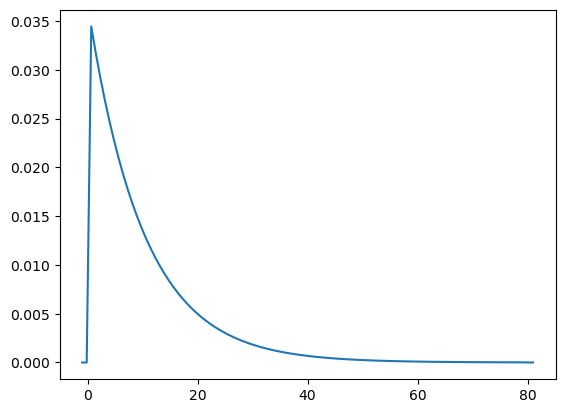

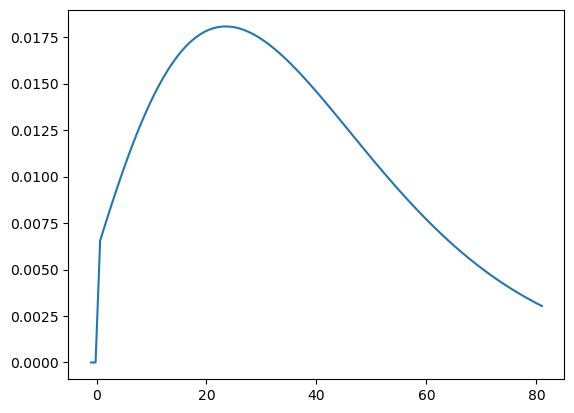

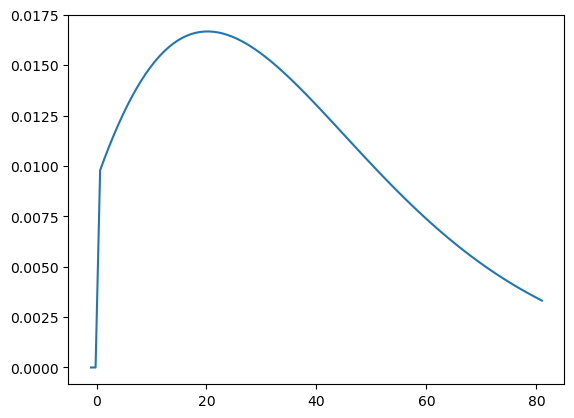

In [9]:

testClaim1 = VariableClaim('test 1', # name
                           'This is a test', #description
                           10.0, # event Rate
                           10.0, # cost mean
                           100.0, # costBound 
                           80, # maxClaim
                           10.0, # deductible
                           80, # policy limit
                           1.0 # policy rate
                          )

#print(testClaim1.get_cost_mean())
#print(testClaim1.get_effective_mean())



#Plotting PDF
xAxis=np.linspace(start=-1
           , stop = testClaim1.get_limit()+1
           , num=100
           )
yAxis = testClaim1.pdf_insurance_cost_single_claim_eval(xAxis)
#yAxis2 = yAxis
#for i in range(len(xAxis)):
#    yAxis2[i] = testClaim1.pdf_insurance_cost_single_claim_eval(xAxis[i])

plt.plot(xAxis,yAxis)
plt.show()
#print(yAxis)
#print(yAxis2-yAxis)

#Plotting PMF
#xAxis=np.zeros(2)
#xAxis[0]=0
#xAxis[1]=testClaim1.get_limit()
#yAxis = testClaim1.pmf_insurance_cost_single_claim_eval(xAxis)
#plt.plot(xAxis,yAxis)
#plt.show()
#print(yAxis)



#Plotting PDF
xAxis=np.linspace(start=-1.0
           , stop = 1.0*testClaim1.get_limit()+1
           , num=100
           )
yAxis = testClaim1.pdf_insurance_cost_multiple_claim_eval(xAxis,10)
#print(yAxis)
plt.plot(xAxis,yAxis)
plt.show()


xAxis=np.linspace(start=-1.0
           , stop = 1.0*testClaim1.get_limit()+1
           , num=100
           )
yAxis = testClaim1.pdf_computational_cost_single_client(xAxis)
#print(yAxis)
plt.plot(xAxis,yAxis)
plt.show()




In [13]:
#x = np.arange(10)
#x2=np.where(x>2 , x,-1)
#x3 = np.where(x2<8,x2,-1)
#print(x3)

#y = np.arange(10) +10
#y2=np.where(x>2 , y,-1)
#y3 = np.where(x2<8,y2,-1)
#print(y3)

#print(y)



#math.pow(y[1],4.3)

testClaim1 = VariableClaim('test 1', # name
                           'This is a test', #description
                           1.0, # event Rate
                           10.0, # cost mean
                           100.0, # costBound 
                           80, # maxClaim
                           10.0, # deductible
                           40, # policy limit
                           1.0 # policy rate
                          )

xAxis=np.linspace(start=0
           , stop = 10.0*testClaim1.get_limit()
           , num=11
           )
#print(testClaim1.get_cost_bound()!=0.0)
y1=testClaim1.pdf_insurance_cost_single_claim_eval(xAxis)
testClaim1.pdf_insurance_cost_single_claim_eval(xAxis)
print(y1)
y2 = testClaim1.pdf_insurance_cost_multiple_claim_eval(xAxis,1)
testClaim1.pdf_insurance_cost_multiple_claim_eval(xAxis,1)
print(y2)

#print(testClaim1)

y3 = testClaim1.pmf_insurance_cost_multiple_claim_eval(xAxis,2)
#print(xAxis)
print(y3)

y4 = testClaim1.pmf_computation_cost_single_client(xAxis)
print(xAxis)
print(y4)

y5= testClaim1.pmf_computation_cost_multiple_clients(xAxis,5)

print(xAxis)
print(y5)


90.0
effective mean calculated: 10.004560907469118
relative difference: 0.00045609074691181276
effective mean calculated: 10.00456094545916
relative difference: 3.797272266658302e-09
effective mean calculated: 10.00456094545916
relative difference: 3.423311266921101e-17
effective mean calculated: 10.00456094545916
relative difference: 3.423311266921101e-17
effective mean calculated: 10.00456094545916
relative difference: 3.423311266921101e-17
effective mean calculated: 10.00456094545916
relative difference: 3.423311266921101e-17
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.         0.00067506 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[3.99400784e-01 8.47869310e-03 4.49975562e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[  0.  40.  80. 120. 160. 200. 240. 280. 320. 360. 400.]
[6.92104469e-01 4.64265185e-03 1.55715049e-05 3.48179979e-08
 5.83899720e-11 7.83362408e

/Users/colingordon/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


OverflowError: int too large to convert to float

In [325]:
#########DDDDDDDDDDDD Depricated

# Input
testPolicy = Policy('test 1', [1.0,2.0,1.5],[100,25,350],0.0,0.0,1.0)


# Testing geters
print('------ testing geters ------')
print('test get deductible')
print(testPolicy.get_deductible())
print('get event rates as array')
print(testPolicy.get_event_rates())
print('get cost means')
print(testPolicy.get_cost_means())
print('get limit')
print(testPolicy.get_limit())
print('get rate')
print(testPolicy.get_rate())

# Testing add_event
print('------ testing add event test ------')
testPolicy.add_event(1.3,1000)
print('event rates')
print(testPolicy.get_event_rates())
print('cost means')
print(testPolicy.get_cost_means())

#Testing remove_event
print('------ Removing an event from the test ------')
testPolicy.remove_event(3)
print('event rates')
print(testPolicy.get_event_rates())
print('cost rates')
print(testPolicy.get_cost_means())

#Testing setters
print('------ Testing setters for policy class ------')
testPolicy.set_deductible(5)
testPolicy.set_limit(25)
testPolicy.set_rate(.25)
testPolicy.set_name('Charlie policy')
print('test set deductible')
print(testPolicy.get_deductible())
print('set limit')
print(testPolicy.get_limit())
print('set rate')
print(testPolicy.get_rate())
# Resetting to previous settings
testPolicy.set_deductible(0)
testPolicy.set_limit(0)
testPolicy.set_rate(1.0)
testPolicy.set_name('test 1')


------ testing geters ------
test get deductible
0.0
get event rates as array
[1.0, 2.0, 1.5]
get cost means
[100, 25, 350]
get limit
0
get rate
1.0
------ testing add event test ------
event rates
[1.0, 2.0, 1.5, 1.3]
cost means
[100, 25, 350, 1000]
------ Removing an event from the test ------
event rates
[1.0, 2.0, 1.5]
cost rates
[100, 25, 350]
------ Testing setters for policy class ------
test set deductible
5
set limit
25
set rate
0.25


In [382]:
arr = [np.zeros(5) for i in range(10)]
print(arr)

[array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.])]


In [472]:
def sum_to_N_with_G_integers(G:int,
                            N:int)->list[tuple[int]]:
    ###########################
    # Synopsis:
    # This function is to list 
    # all permutations where
    # the sum of G positive integers
    # (>=0) that equate to the
    # integer N
    # 
    #
    #
    # OUTPUT:
    # a list of tuples containg
    # integers where each tuple is 
    # a permuation of numbers that
    # sum to N
    # 
    ###########################
    #HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH HELPER FUNCTION
    def sum_to_N(G:int,
                 N:int,
                 prevSum:int,
                 loopNumber:int,
                 arr:tuple[int],
                 ListPerm:list[tuple[int]]):
        # copying array to avoid overwriting
        # list items
        arra = arr.copy()
        for i in range((N+1-prevSum)):
            numSum = prevSum + i
            if(numSum==N):
                arra[loopNumber] = i
                ListPerm.append(arra)
                break
            elif(loopNumber<G-1):
                arra[loopNumber] = i
                loopy = loopNumber+1
                sum_to_N(G,
                        N,
                        numSum,
                        loopy,
                        arra,
                        ListPerm)
    #MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM FUNCTION MAIN
    ListTest = []            
    for j in range((N+1)):
        # Initiating a new array 
        arrary = [0 for i in range(G)]
        arrary[0] = j
        sum_to_N(G,N,j,1,arrary,ListTest)
    return ListTest

print(sum_to_N_with_G_integers(4,20))


[[0, 0, 0, 20], [0, 0, 1, 19], [0, 0, 2, 18], [0, 0, 3, 17], [0, 0, 4, 16], [0, 0, 5, 15], [0, 0, 6, 14], [0, 0, 7, 13], [0, 0, 8, 12], [0, 0, 9, 11], [0, 0, 10, 10], [0, 0, 11, 9], [0, 0, 12, 8], [0, 0, 13, 7], [0, 0, 14, 6], [0, 0, 15, 5], [0, 0, 16, 4], [0, 0, 17, 3], [0, 0, 18, 2], [0, 0, 19, 1], [0, 0, 20, 0], [0, 1, 0, 19], [0, 1, 1, 18], [0, 1, 2, 17], [0, 1, 3, 16], [0, 1, 4, 15], [0, 1, 5, 14], [0, 1, 6, 13], [0, 1, 7, 12], [0, 1, 8, 11], [0, 1, 9, 10], [0, 1, 10, 9], [0, 1, 11, 8], [0, 1, 12, 7], [0, 1, 13, 6], [0, 1, 14, 5], [0, 1, 15, 4], [0, 1, 16, 3], [0, 1, 17, 2], [0, 1, 18, 1], [0, 1, 19, 0], [0, 2, 0, 18], [0, 2, 1, 17], [0, 2, 2, 16], [0, 2, 3, 15], [0, 2, 4, 14], [0, 2, 5, 13], [0, 2, 6, 12], [0, 2, 7, 11], [0, 2, 8, 10], [0, 2, 9, 9], [0, 2, 10, 8], [0, 2, 11, 7], [0, 2, 12, 6], [0, 2, 13, 5], [0, 2, 14, 4], [0, 2, 15, 3], [0, 2, 16, 2], [0, 2, 17, 1], [0, 2, 18, 0], [0, 3, 0, 17], [0, 3, 1, 16], [0, 3, 2, 15], [0, 3, 3, 14], [0, 3, 4, 13], [0, 3, 5, 12], [0, 3, 6,

In [464]:
# MODIFYING AND TESTING SUM_TO_N_WITH_G_INTEGERS

def sum_to_N_with_G_integers(G:int,
                            N:int)->list[tuple[int]]:
    ###########################
    # Synopsis:
    # This function is to list 
    # all permutations where
    # the sum of G positive integers
    # (>=0) that equate to the
    # integer N
    # 
    #
    #
    # OUTPUT:
    # a list of tuples containg
    # integers where each tuple is 
    # a permuation of numbers that
    # sum to N
    # 
    ###########################
    #HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH HELPER FUNCTIONS
    def check_sum(i:int,
                 G:int,
                 N:int,
                 prevSum:int,
                 loopNumber:int,
                 arra:tuple[int],
                 ListPerm:list[tuple[int]]):
        numSum = prevSum + i
        if(numSum==N):
            arra[loopNumber] = i
            ListPerm.append(arra)
            #break
        elif(loopNumber<G-1):
            arra[loopNumber] = i
            loopy = loopNumber+1
            sum_to_N(G,
                    N,
                    numSum,
                    loopy,
                    arra,
                    ListPerm)
            arra[loopy]=0
    
    def sum_to_N(G:int,
                 N:int,
                 prevSum:int,
                 loopNumber:int,
                 arr:tuple[int],
                 ListPerm:list[tuple[int]]):
        # copying array to avoid overwriting
        # list items
        arra = arr.copy()
        num_cores = multiprocessing.cpu_count()
        iteration=range((N+1))
        #Parallel(n_jobs = num_cores)(delayed(check_sum)(i,G,N,prevSum,loopNumber,arra,ListPerm)for i in iteration)
        for i in iteration:
            check_sum(i,G,N,prevSum,loopNumber,arra,ListPerm)
    def first_loop(G:int,
                 N:int,
                 j:int,
                 ListTest:list[tuple[int]]):
        # Initiating a new array 
        num_cores = multiprocessing.cpu_count()
        arrary = [0 for i in range(G)]
        arrary[0] = j
        sum_to_N(G,N,j,1,arrary,ListTest)
    #MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM FUNCTION MAIN
    ListTest = []            
    num_cores = multiprocessing.cpu_count()
    iteration=range((N+1))
    #Parallel(n_jobs = num_cores)(delayed(first_loop)(G,N,j,ListTest)for j in iteration)
    for j in iteration:
        first_loop(G,N,j,ListTest) 
    return ListTest

print(sum_to_N_with_G_integers(3,6))


[[0, 0, 6], [0, 1, 5], [0, 2, 4], [0, 3, 3], [0, 4, 2], [0, 5, 1], [0, 6, 0], [1, 0, 5], [1, 1, 4], [1, 2, 3], [1, 3, 2], [1, 4, 1], [1, 6, 0], [2, 0, 4], [2, 1, 3], [2, 2, 2], [2, 3, 1], [2, 6, 0], [3, 0, 3], [3, 1, 2], [3, 2, 1], [3, 6, 0], [4, 0, 2], [4, 1, 1], [4, 6, 0], [5, 0, 1], [5, 6, 0], [6, 6, 0]]
[1, 0, 5]
[1, 1, 4]
[1, 3, 2]
[1, 4, 1]
[1, 5, 0]
[1, 2, 3]
[3, 0, 3]
[3, 1, 2]
[3, 3, 0]
[3, 2, 1]


In [15]:
wait = np.zeros((6,10))
print(wait)
print('-----------------')
#print(wait[1,:])

testRowChange = np.array([1,2,3,4,5,6,7,8,9,10])
#print(testRowChange)
wait[1,:] = testRowChange
print(wait)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
-----------------
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [74]:
inputVar = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
#output=np.zeros(len(inputVar))
def testingParallel(x:np.array,index:int):
    return x[index]*x[index]
    

num_cores = multiprocessing.cpu_count()
#print('the number of cores is: '+str(num_cores))
iteration=range(len(inputVar))
output = np.array(Parallel(n_jobs = num_cores)(delayed(testingParallel)(inputVar,j)for j in iteration))
print(output)

#for j in range(len(modedCosts)):
#    evaluatePMFPoint(j,distribution)

                

    

[  0   1   4   9  16  25  36  49  64  81 100 121 144 169 196 225]


In [ ]:
# Previous version before parrallization
def pmf_computation_cost_multiple_clients(self,
                                             costs: np.array,
                                             clientNumber: int)->np.array:
        ###########################
        # Synopsis:
        # This is the distribution of 
        # cost of the policy when the client
        # have to up to __MaxClaim claims
        # for the variable claim type. 
        # This method assumes that the claims
        # follow a Poisson distribution 
        # given by the event rate of the claim per 
        # a client. We then 
        #
        #
        # OUTPUT:
        # the probability mass 
        # of the evaluated cost
        # 
        ###########################
        
        # these are the permuations that are used to calculate all sums to N (clientNumber)
        permutations = self.sum_to_N_with_G_integers(self.get_max_claim(),clientNumber)
        
        # this is the probabilities of having y claims as poissonProb[y]
        # an poissonProb[self.get_max_claim()] = P(y>=self.get_max_claim())
        poissonProb = np.zeros((self.get_max_claim()+1))
        
        # this generates the values to be used
        yFact = 1.0
        poissonProb[0] = 1.0
        poissonRate = 1.0
        cumPoisson = 1.0
        for y in range(1,self.get_max_claim()):
            yFact = y*yFact
            poissonRate = poissonRate*self.get_event_rate()
            poissonProb[y] = poissonRate/yFact
            cumPoisson = cumPoisson + poissonProb[y]
        poissonProb = math.exp(-1.0*self.get_event_rate())*poissonProb
        cumPoisson = math.exp(-1.0*self.get_event_rate())*cumPoisson
        poissonProb[self.get_max_claim()] = 1.0-cumPoisson
        # poisson values are generated for use 
        def one_permutation(costs:np.array,
                           poisson:np.array,
                           perms:list[tuple[int]],
                           permIndex:int,
                           multPerm:np.array,
                           clientNum:int):
            # one permutation
            perm = perms[permIndex]
            prodPois = math.factorial(clientNum)
            sumPois = 0.0
            y=0
            for q in perm:
                sumPois = y*q + sumPois
                prodPois= ((poisson[y]**q)*prodPois)/math.factorial(q)
                y=y+1
            multPerm[permIndex,:] = prodPois*self.pmf_insurance_cost_multiple_claim_eval(costs,int(sumPois))
        
        
        multPerm = np.zeros((len(permutations),len(costs)))
        # we can paralize the evaluation of each point
        #num_cores = multiprocessing.cpu_count()
        #print('the number of cores is: '+str(num_cores))
        #Parallel(n_jobs = num_cores)(delayed(one_permutation)(costs,poissonProb,permutations,j,multPerm,clientNumber)for j in range(len(permutations)))        
        ######################## SERIAL APPROACH
        for j in range(len(permutations)):
            one_permutation(costs,poissonProb,permutations,j,multPerm,clientNumber)
        
        
        #print(multPerm)
        distribution = np.zeros(len(costs))
        for row in range(len(permutations)):
            distribution = distribution + multPerm[row,:] 
        return distribution

In [ ]:
def working_sum_kintegers(sum, k):
    if k < 1:
        return []
    if k == 1:
        return [(sum,)]
    if k == 2:
        return [(i,sum-i) for i in range(1, sum-k+2)]
    
    return [tup[:-1] + ab for tup in working_sum_kintegers(sum, k-1) for ab in working_sum_kintegers(tup[-1], 2)]

print(working_sum_kintegers(20,5))